## Generating Explanation using TreeSurrogate (Classification/Regression)

### 1. Classification example using Iris dataset

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from skater.util.dataops import show_in_notebook
import pandas as pd
import numpy as np

iris = load_iris()

# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)
X = df
y = iris.target

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=10, class_weight="balanced", oob_score=True, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=1,
            verbose=0, warm_start=False)

In [3]:
y_hat_train = clf.predict(X_train)
y_hat = clf.predict(X_test)

In [4]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        31
    class 1       0.97      0.97      0.97        35
    class 2       0.97      0.97      0.97        34

avg / total       0.98      0.98      0.98       100


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       1.00      1.00      1.00        15
    class 2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



In [5]:
print(np.unique(y_hat))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


#### Vizualizing boundaries

In [6]:
%matplotlib inline
from skater.core.visualizer import decision_boundary as db
_, _ = db.plot_decision_boundary(clf, X0=X_train.iloc[:, 0], X1=X_train.iloc[:, 1], 
                                 Y=y_train, mode='interactive', height=6, width=10, file_name='iplot')

<Figure size 432x288 with 0 Axes>

#### Visualizing individual trees using Skater and ipywidgets

In [7]:
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text

def generate_plot(est, tree_index):
    g = plot_tree(est.estimators_[tree_index], feature_names=iris.feature_names, class_names=iris.target_names, 
              color_list=['thistle', 'slategrey', 'snow'])
    g.write_png('estimator{}.png'.format(tree_index))
    show_in_notebook('./estimator{}.png'.format(tree_index))

In [12]:
#!conda install ipywidgets --yes
#!jupyter nbextension enable --py --sys-prefix widgetsnbextension

# One could further improve this by setting up an event callback using
# asynchronous widgets
from ipywidgets import widgets, Box, HBox, Layout, Button, Label
from ipywidgets import interactive
from IPython.display import display, Javascript
from IPython.display import clear_output


# dropdown to select the tree estimator to be visualized,
estimator_slector = widgets.Dropdown(
    options= list(range(len(clf.estimators_))),
    value=0,
    disabled=False,
)

# Reference: http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
button = widgets.Button(description="Visualize Trees")
button.style.button_color = 'lightgreen'

In [13]:
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

form_items = [
    Box([Label(value='Tree Index'), estimator_slector], layout=form_item_layout),
    Box([Label(value='Click Me -->'), button ], layout=form_item_layout)
]

In [14]:
def generate_plot_event(button_func_ref):
    generate_plot(clf, estimator_slector.value)

button.on_click(generate_plot_event)

form = HBox(form_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='40%'
))

display(form)

A Jupyter Widget

#### Explaination using Pre-pruned TreeSurrogate

In [15]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO

interpreter = Interpretation(X_train, feature_names=iris.feature_names)
model_inst = InMemoryModel(clf.predict, examples=X_train, model_type='classifier', unique_values=[0, 1],
                           feature_names=iris.feature_names, target_names=iris.target_names, log_level=_INFO)
# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

In [16]:
# Using the surrogate model learn the decision boundaries learned by the base estimator
# Also report fidelity value when compared to the base estimator
# Learner uses F1 metric as the default metric of choice for classification.
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-23 18:31:16,764 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-23 18:31:16,765 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-23 18:31:16,911 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (100,)
2018-09-23 18:31:16,913 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.97; oracle score 0.98


0.01

In [17]:
surrogate_explainer.splitter

'best'

2018-09-23 18:31:18,127 - skater.util.dataops - INFO - File Name: simple_tree_pre.png


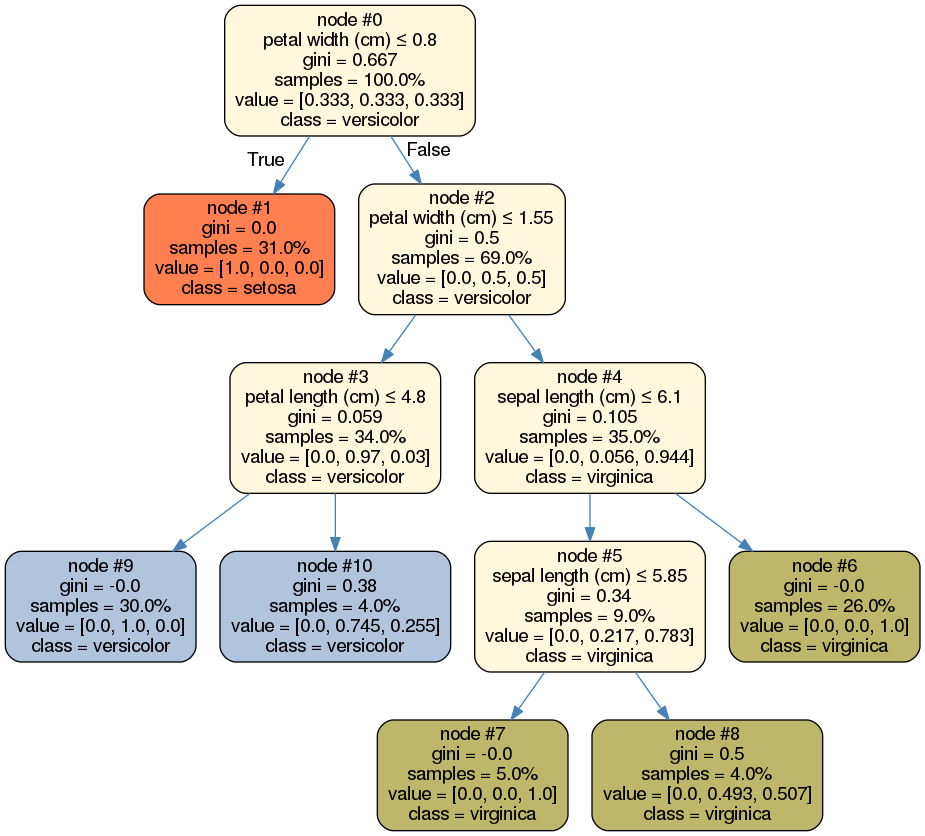

In [18]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                          file_name='simple_tree_pre.png')
show_in_notebook('simple_tree_pre.png', width=400, height=300)

In [19]:
surrogate_explainer.decisions_as_txt()

if petal width (cm) <= 0.800000011920929 {
    Predicted Label: 0
} else {
  if petal width (cm) <= 1.5499999523162842 {
    if petal length (cm) <= 4.800000190734863 {
        Predicted Label: 1
    } else {
        Predicted Label: 1
    }
  } else {
    if sepal length (cm) <= 6.099999904632568 {
      if sepal length (cm) <= 5.850000381469727 {
          Predicted Label: 2
      } else {
          Predicted Label: 2
      }
    } else {
        Predicted Label: 2
    }
  }
}


In [20]:
# Generating classification metric using the surrogate model(pre-pruning)
# If the performance of a trimmed tree is equivalent to that of a base estimator and interpretability is important
# the surrogate model could possibly be used as the final model as well. 
# However, care must be taken to make sure the results are accurate.
y_hat_pre = surrogate_explainer.predict(X_test)
print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_pre, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       0.93      0.87      0.90        15
    class 2       0.88      0.94      0.91        16

avg / total       0.94      0.94      0.94        50



#### Evaluating individual prediction

In [21]:
sample_index = 6
X_test.iloc[sample_index]

sepal length (cm)    5.6
sepal width (cm)     2.9
petal length (cm)    3.6
petal width (cm)     1.3
Name: 64, dtype: float64

In [22]:
print("Oracle Model {}:".format(clf.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [1]:
Using TreeSurrogate [1]:


In [23]:
surrogate_explainer.decisions_as_txt('local', X_test.iloc[sample_index])

As petal width (cm)[1.3] > 0.800000011920929 then,
  As petal width (cm)[1.3] <= 1.5499999523162842 then,
    As petal length (cm)[3.6] <= 4.800000190734863 then,
        Predicted Label: 1


#### Explaination using TreeSurrogate with post-pruning

In [24]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
# without any pruning
surrogate_explainer2.fit(X_train, y_train, use_oracle=True, prune=None, scorer_type='default')

2018-09-23 18:31:21,267 - skater.core.global_interpretation.tree_surrogate - INFO - No pruning applied ...
2018-09-23 18:31:21,269 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (100,)
2018-09-23 18:31:21,271 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 1.0; oracle score 0.98


-0.02

In [25]:
y_hat_post = surrogate_explainer2.predict(X_test)
print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_hat_post, target_names=target_names))


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        19
    class 1       0.94      1.00      0.97        15
    class 2       1.00      0.94      0.97        16

avg / total       0.98      0.98      0.98        50



2018-09-23 18:31:22,337 - skater.util.dataops - INFO - File Name: simple_tree.png


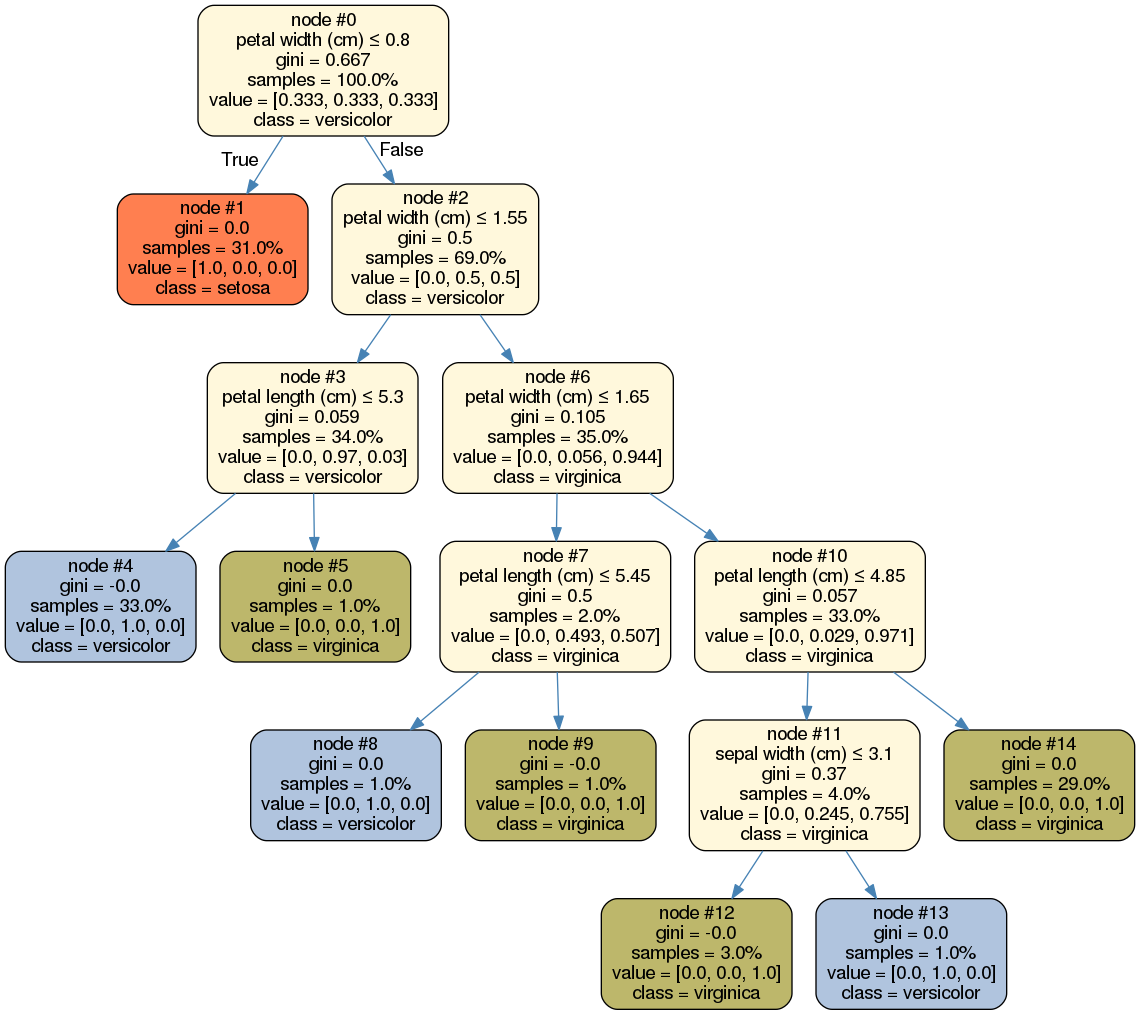

In [26]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                           file_name='simple_tree.png')
show_in_notebook('simple_tree.png', width=400, height=300)

In [27]:
surrogate_explainer2.fit(X_train, y_train, use_oracle=True, prune='post', scorer_type='default', verbose=True)

2018-09-23 18:31:22,655 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-23 18:31:22,658 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in ground truth provided [0 1 2]
2018-09-23 18:31:22,659 - skater.core.global_interpretation.tree_surrogate - DEBUG - Unique Labels in predictions generated [0 1 2]
2018-09-23 18:31:22,660 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-09-23 18:31:22,662 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-23 18:31:22,664 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.1814814814814815
2018-09-23 18:31:22,665 - skater.core.global_interpretation.tree_surrogate - DEBUG - Added index 0 back
2018-09-23 18:31:22,667 - skater.core.global_interpretation.tree_surrogate - DEBUG - new score generate 0.5455769230769231
2018-09-23 18:31:22,667 - skater.core.global_interpr

-0.01

2018-09-23 18:31:23,476 - skater.util.dataops - INFO - File Name: simple_tree_post.png


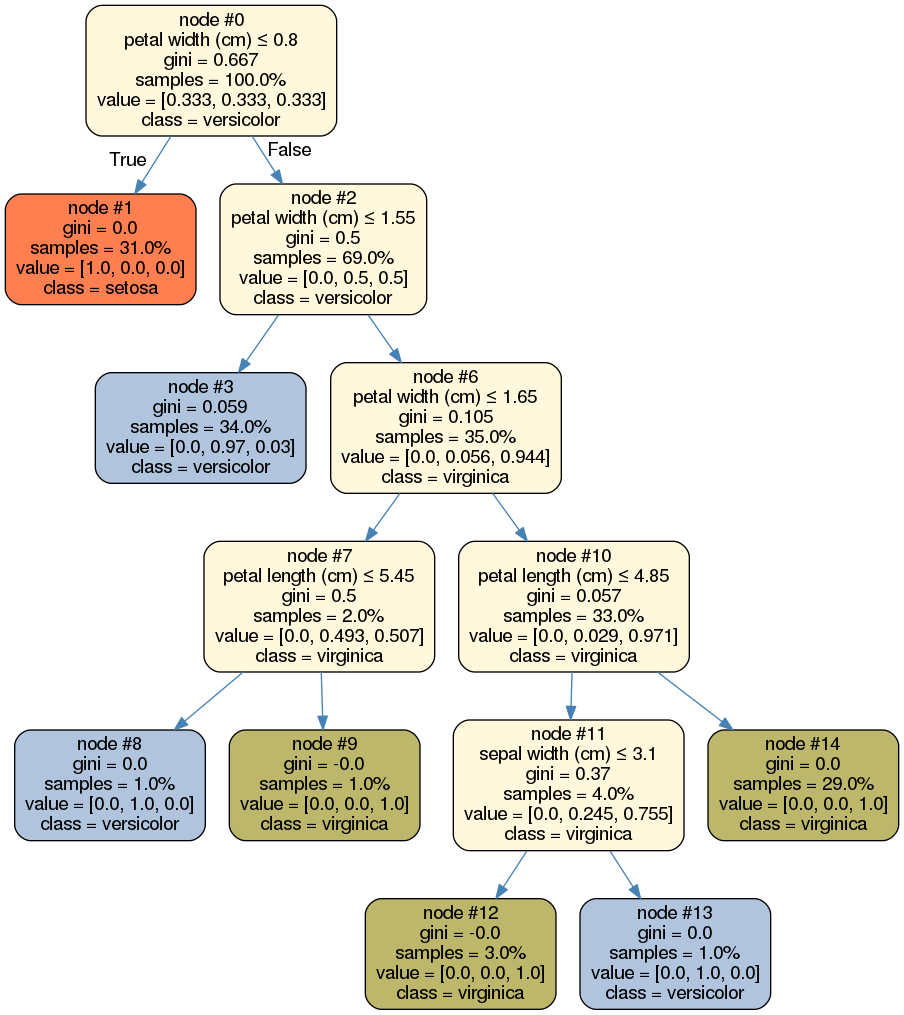

In [28]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'], 
                                           file_name='simple_tree_post.png')
show_in_notebook('simple_tree_post.png', width=400, height=300)

### 2. Regression example

In [39]:
from sklearn.datasets import load_boston
from sklearn.ensemble.forest import RandomForestRegressor
boston = load_boston()

# Create a dataframe with the four feature variables
df = pd.DataFrame(boston.data, columns=boston.feature_names)
X = df
y = boston.target

# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

est = RandomForestRegressor(n_estimators=20, bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)
est.fit(X_train, y_train)

y_hat_reg_train = est.predict(X_train)
y_hat_reg = est.predict(X_test)


print("Train Evaluation ...")
from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_reg_train))

print("Test Evaluation ...")
# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_hat_reg))

Train Evaluation ...
0.9719159780399518
Test Evaluation ...
0.836224040010425


In [42]:
interpreter = Interpretation(X_train, feature_names=boston.feature_names)
model_inst = InMemoryModel(est.predict, examples=X_train, model_type='regressor',
                           feature_names=boston.feature_names, log_level=_INFO)

surrogate_explainer_reg = interpreter.tree_surrogate(oracle=model_inst, seed=5)

In [43]:
# The score returned is the fidelity score = difference in performance between the values returned by the Oracle and
# the surrogate model. If the difference is big then the surrogate model most likely is not a good representation
# of the base model.
surrogate_explainer_reg.fit(X_train, y_train, use_oracle=True, scorer_type='r2', prune='post', verbose=False)

2018-09-23 18:34:54,919 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-23 18:34:54,929 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used R2
2018-09-23 18:34:54,930 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-23 18:34:55,041 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [4, 5, 6, 8, 9, 13, 14, 15, 20, 21, 25, 32, 33, 34, 36, 38, 41, 43, 44, 45, 48, 49, 50, 51, 54, 57, 58, 59, 66, 68, 75, 76, 77, 80, 82, 85, 87, 88, 91, 93, 97, 98, 99, 100, 102, 104, 107, 109, 112, 113, 114, 117, 121, 123, 124, 127, 130, 131, 132, 133, 136, 137, 140, 141, 145, 148, 149, 150, 153, 154, 155, 156, 158, 160, 164, 165, 168, 169, 170, 173, 175, 178, 179, 182, 183, 185, 186, 189, 192, 193, 197, 198, 199, 200, 201, 202, 205, 206, 212, 213, 214, 218, 221, 223, 225, 228, 229, 230, 233, 236, 237, 238, 242, 244, 245, 251, 2

-0.018

In [44]:
y_hat_reg_train_s = surrogate_explainer_reg.predict(X_train)
y_hat_reg_s = surrogate_explainer_reg.predict(X_test)


print("Train Evaluation ...")
from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_reg_train_s))

print("Test Evaluation ...")
# Using R^2(Coefficient of Determination for evaluation)
from sklearn.metrics import r2_score
print(r2_score(y_test, y_hat_reg_s))

Train Evaluation ...
0.9554692179873144
Test Evaluation ...
0.8328938396105487


In [45]:
%matplotlib inline
surrogate_explainer_reg.plot_global_decisions(file_name='simple_tree_reg.png')
#show_in_notebook('simple_tree_reg.png', width=1400, height=700)

In [46]:
# Disable this line to get an interactive plot to zoom in and out
# show_in_notebook('simple_tree_reg.png', width=1000, height=800, mode='interactive')

#### Evaluating individual prediction

In [47]:
sample_index = 6
X_test.iloc[sample_index]

CRIM         0.31827
ZN           0.00000
INDUS        9.90000
CHAS         0.00000
NOX          0.54400
RM           5.91400
AGE         83.20000
DIS          3.99860
RAD          4.00000
TAX        304.00000
PTRATIO     18.40000
B          390.70000
LSTAT       18.33000
Name: 316, dtype: float64

In [48]:
print("Oracle Model {}:".format(est.predict(X_test.iloc[sample_index].values.reshape(1, -1))))
print("Using TreeSurrogate {}:".format(surrogate_explainer_reg.predict(X_test.iloc[sample_index].values.reshape(1, -1))))

Oracle Model [20.07]:
Using TreeSurrogate [19.36]:


In [49]:
surrogate_explainer_reg.decisions_as_txt('local', X_test.iloc[sample_index])

As RM[5.914] <= 6.837500095367432 then,
  As LSTAT[18.33] > 14.399999618530273 then,
    As CRIM[0.31827] <= 7.084139823913574 then,
      As CRIM[0.31827] <= 0.6147900223731995 then,
        As DIS[3.9986] > 1.9799000024795532 then,
          As AGE[83.2] > 73.30000305175781 then,
            As CRIM[0.31827] > 0.17127001285552979 then,
              As CHAS[0.0] <= 0.5 then,
                As B[390.7] <= 391.875 then,
                  As NOX[0.544] > 0.48649999499320984 then,
                    As B[390.7] > 389.96002197265625 then,
                        Value: [[19.36]]
